Raw shape: (24352, 2882)


c:\Users\ibrah\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ibrah\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\ibrah\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ibrah\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\ibrah\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

Hierarchical ARI: 0.468


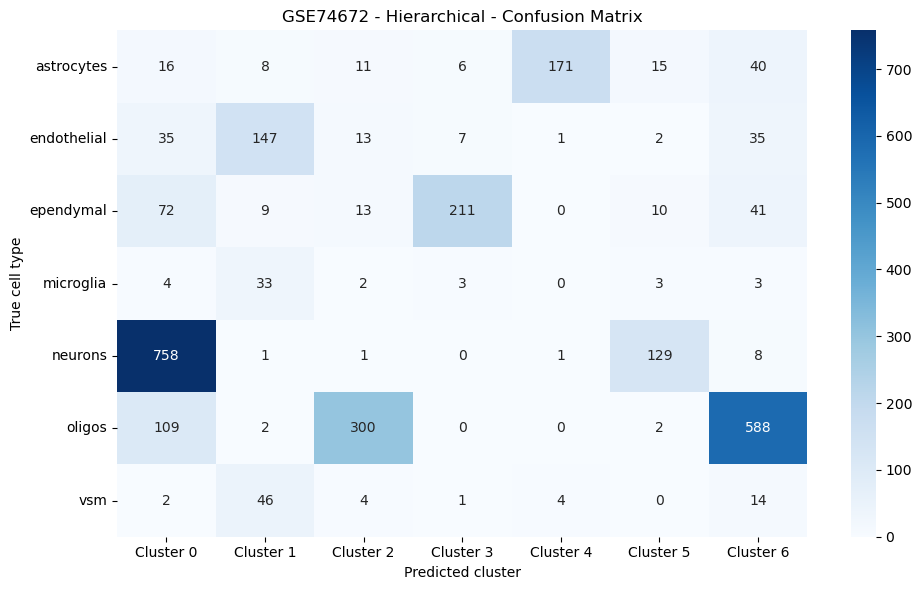

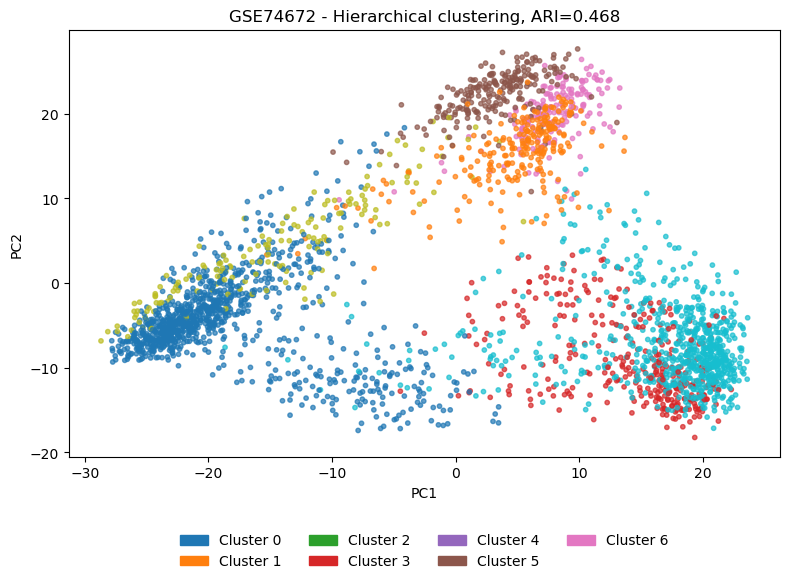

KMeans ARI: 0.499


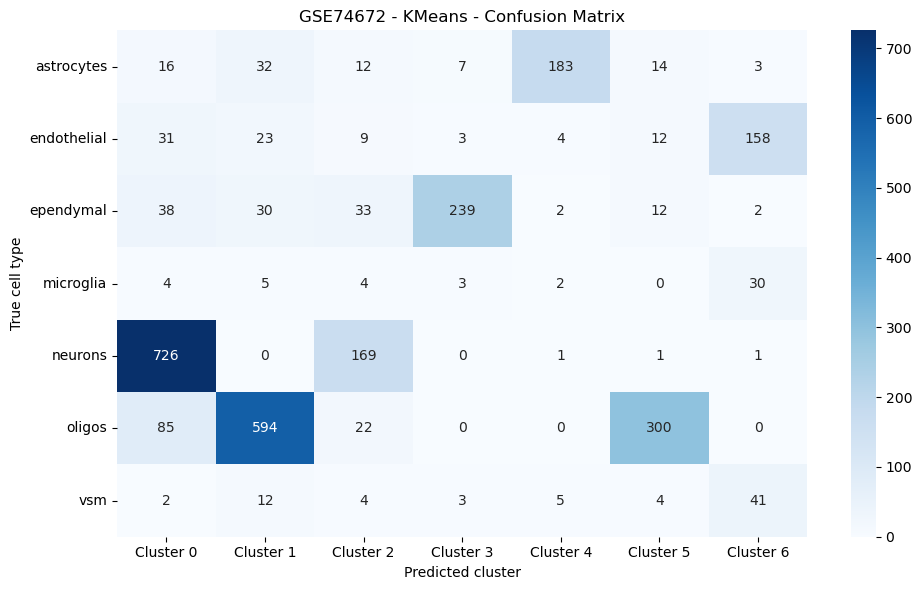

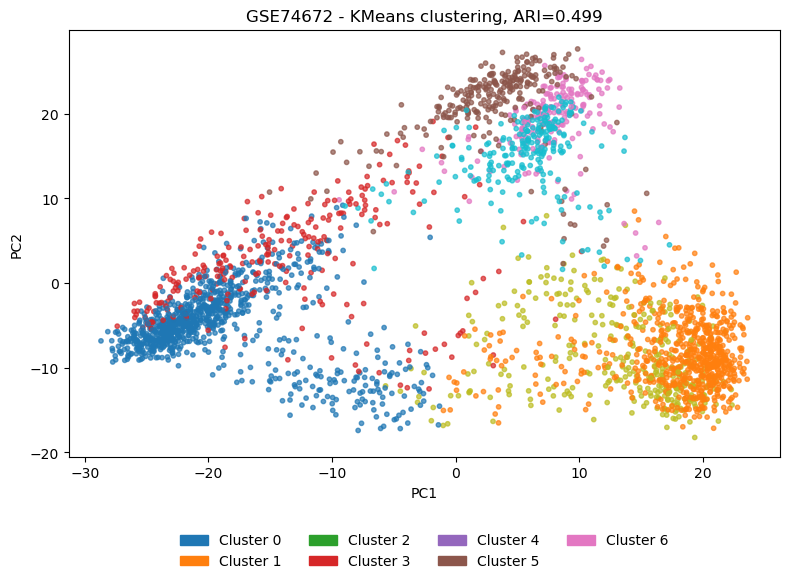

DBSCAN_UMAP ARI: 0.553


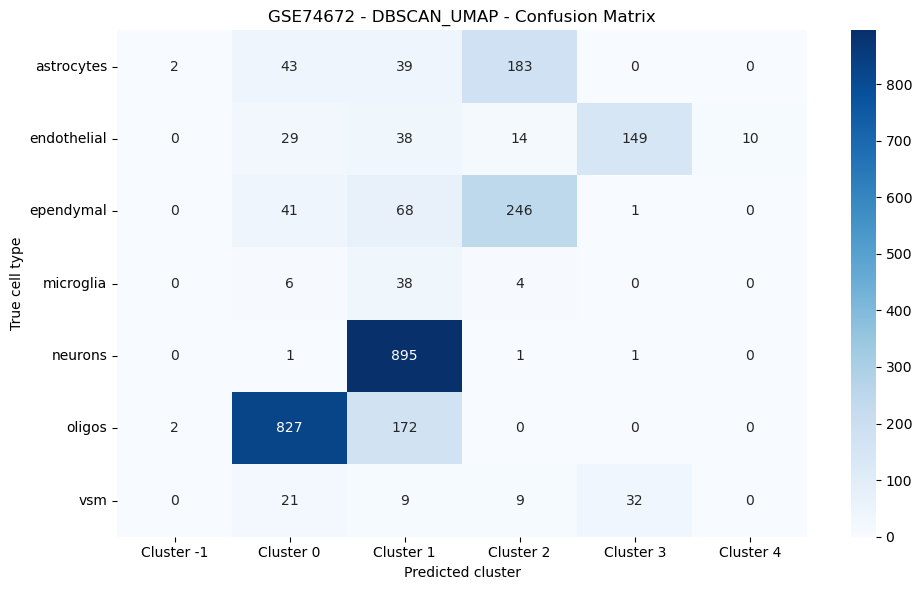

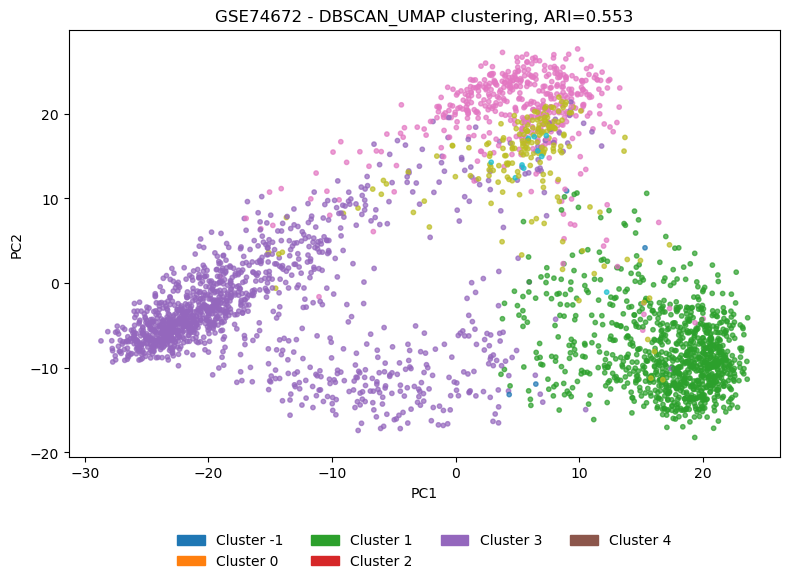

Leiden ARI: 0.438


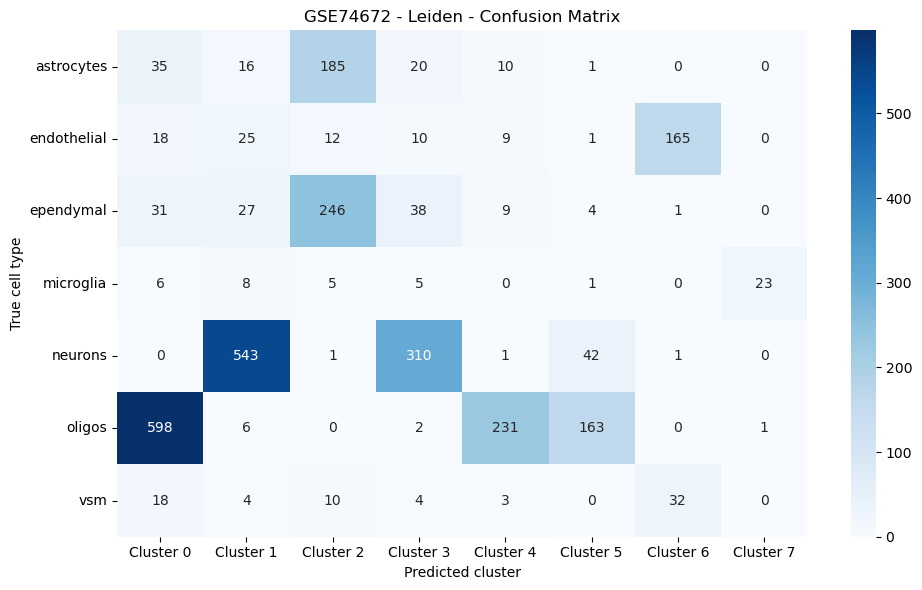

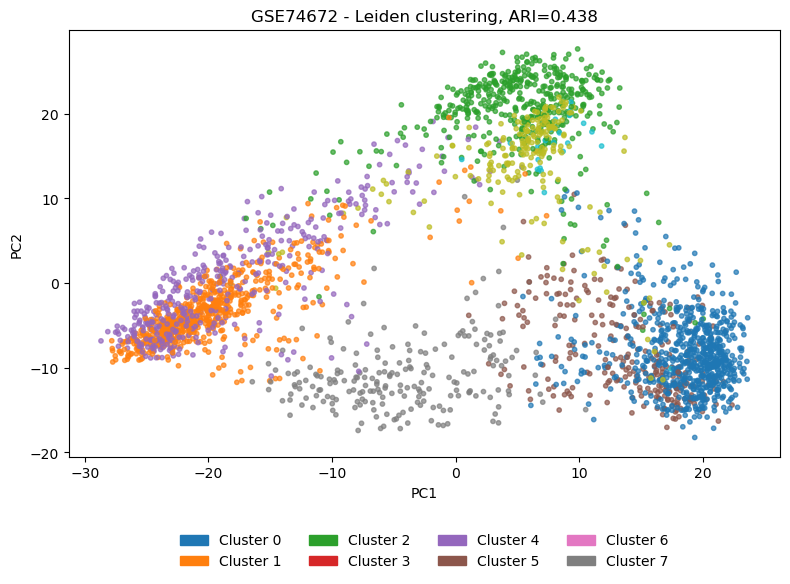

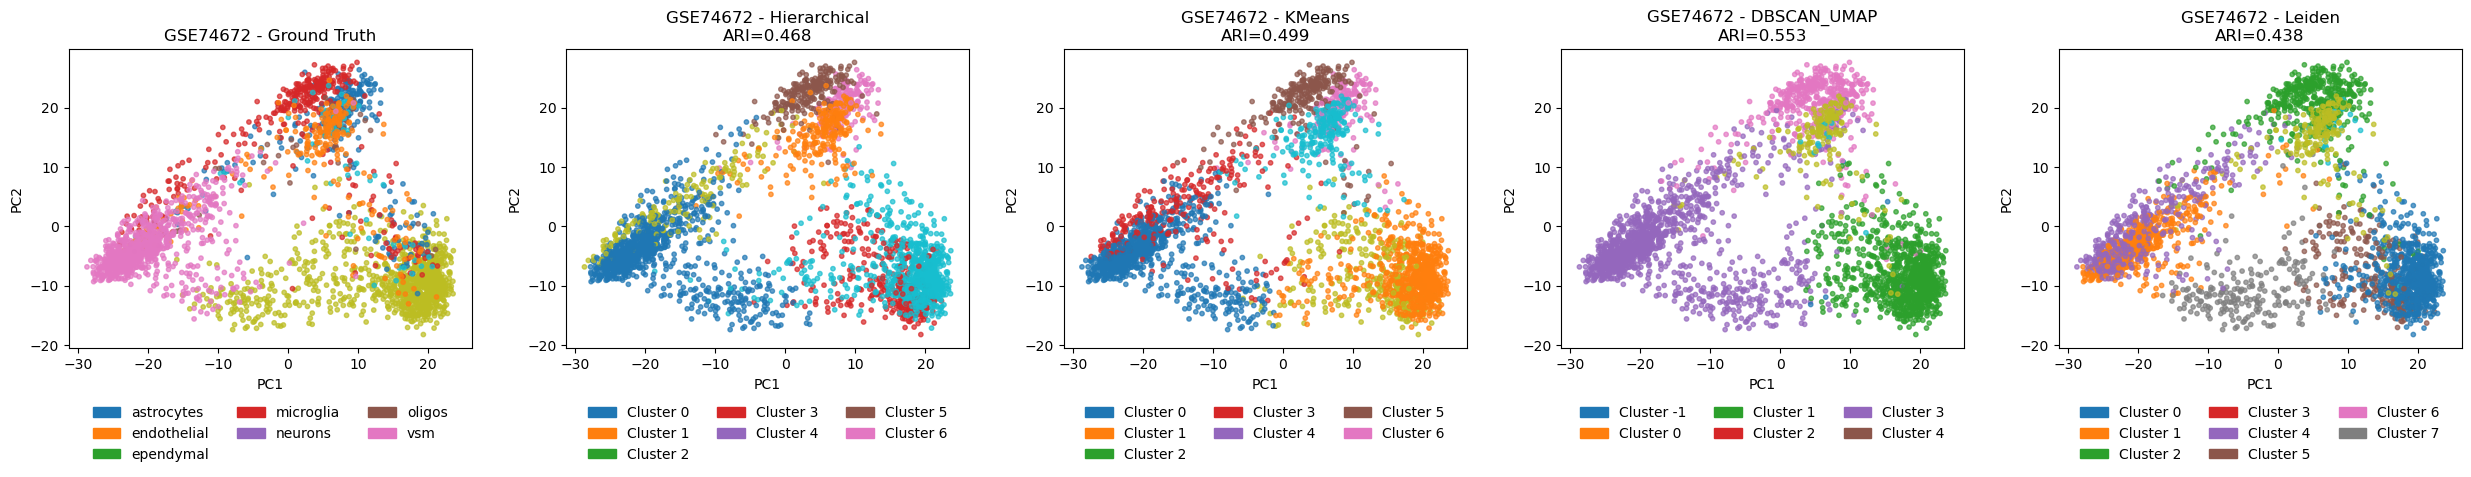

In [ ]:
import gzip
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import umap
import matplotlib.patches as mpatches

dataset_name = "GSE74672"

gz_path = r"C:\Users\ibrah\OneDrive\Pictures\Bracu courses\CSE443\GSE74672_expressed_mols_with_classes.xlsx.gz"
with gzip.open(gz_path, 'rb') as f:
    df = pd.read_excel(f, engine="openpyxl")

print("Raw shape:", df.shape)

df.set_index(df.columns[0], inplace=True)
meta = df.iloc[0:8, :]
expr = df.iloc[8:, :]

expr = expr.apply(pd.to_numeric, errors='coerce').fillna(0)

true_labels = meta.loc["level1 class"]

# Preprocess
X = expr.T.astype(np.float32)
X = X.loc[X.sum(axis=1) > 0]
true_labels_aligned = true_labels.loc[X.index]

# Normalize & log-transform
X = X.div(X.sum(axis=1), axis=0) * 1e4
X = X.fillna(0)
X_log = np.log1p(X)

X_log.columns = X_log.columns.astype(str)

X_pca = PCA(n_components=20, random_state=0).fit_transform(X_log)

results = {}

# Hierarchical
hc = AgglomerativeClustering(n_clusters=len(np.unique(true_labels_aligned)), linkage='ward')
results['Hierarchical'] = hc.fit_predict(X_pca)

# K-Means
km = KMeans(n_clusters=len(np.unique(true_labels_aligned)), n_init=10, random_state=0)
results['KMeans'] = km.fit_predict(X_pca)

# DBSCAN with UMAP preprocessing
reducer = umap.UMAP(n_components=2, random_state=0, n_neighbors=15, min_dist=0.1)
X_umap = reducer.fit_transform(X_log.values)
db = DBSCAN(eps=0.5, min_samples=5)
results['DBSCAN_UMAP'] = db.fit_predict(X_umap)

# Leiden clustering (via Scanpy)
adata = sc.AnnData(X_log)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
sc.tl.leiden(adata, resolution=1.0, key_added="leiden")
results['Leiden'] = adata.obs['leiden'].astype(int).values

# Evaluation
for method, pred in results.items():
    le = LabelEncoder()
    true_labels_encoded = le.fit_transform(true_labels_aligned)
    ari = adjusted_rand_score(true_labels_encoded, pred)
    print(f"{method} ARI: {ari:.3f}")

    # Confusion matrix
    true_class_ids = np.unique(true_labels_encoded)
    pred_class_ids = np.unique(pred)

    cm_full = np.zeros((len(true_class_ids), len(pred_class_ids)), dtype=int)
    for i, t in enumerate(true_class_ids):
        for j, p in enumerate(pred_class_ids):
            cm_full[i, j] = np.sum((true_labels_encoded == t) & (pred == p))

    row_labels = le.inverse_transform(true_class_ids)
    col_labels = [f"Cluster {c}" for c in pred_class_ids]

    cm_df = pd.DataFrame(cm_full, index=row_labels, columns=col_labels)

    plt.figure(figsize=(10, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{dataset_name} - {method} - Confusion Matrix")
    plt.ylabel("True cell type")
    plt.xlabel("Predicted cluster")
    plt.tight_layout()
    plt.show()

    # Scatter (2D PCA)
    X2 = PCA(n_components=2, random_state=0).fit_transform(X_log)
    plt.figure(figsize=(8, 6))
    plt.scatter(X2[:, 0], X2[:, 1], c=pred, cmap='tab10', s=10, alpha=0.7)
    plt.title(f"{dataset_name} - {method} clustering, ARI={ari:.3f}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    if method == "Ground Truth":
        unique_classes = le.classes_
        colors = [plt.cm.tab10(i) for i in range(len(unique_classes))]
        patches = [mpatches.Patch(color=colors[i], label=unique_classes[i])
                   for i in range(len(unique_classes))]
    else:
        cluster_ids = np.unique(pred)
        colors = [plt.cm.tab10(i % 10) for i in range(len(cluster_ids))]
        patches = [mpatches.Patch(color=colors[i], label=f"Cluster {cid}")
                   for i, cid in enumerate(cluster_ids)]

    plt.legend(handles=patches, bbox_to_anchor=(0.5, -0.15),
               loc='upper center', ncol=4, frameon=False)
    plt.tight_layout()
    plt.show()

# Encode ground truth labels
le = LabelEncoder()
true_labels_encoded = le.fit_transform(true_labels_aligned)

# Collect all clusterings including ground truth
all_results = {"Ground Truth": true_labels_encoded}
all_results.update(results)

# 2D PCA embedding for visualization
X2 = PCA(n_components=2, random_state=0).fit_transform(X_log)

# Final comparison plots
fig, axes = plt.subplots(1, len(all_results), figsize=(5 * len(all_results), 5))

for ax, (method, pred) in zip(axes, all_results.items()):
    ax.scatter(X2[:, 0], X2[:, 1], c=pred, cmap='tab10', s=10, alpha=0.7)
    if method == "Ground Truth":
        ax.set_title(f"{dataset_name} - {method}")
        unique_classes = le.classes_
        colors = [plt.cm.tab10(i) for i in range(len(unique_classes))]
        patches = [mpatches.Patch(color=colors[i], label=unique_classes[i])
                   for i in range(len(unique_classes))]
    else:
        ari = adjusted_rand_score(true_labels_encoded, pred)
        ax.set_title(f"{dataset_name} - {method}\nARI={ari:.3f}")
        cluster_ids = np.unique(pred)
        colors = [plt.cm.tab10(i % 10) for i in range(len(cluster_ids))]
        patches = [mpatches.Patch(color=colors[i], label=f"Cluster {cid}")
                   for i, cid in enumerate(cluster_ids)]

    ax.legend(handles=patches, bbox_to_anchor=(0.5, -0.15),
              loc='upper center', ncol=3, frameon=False)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

plt.tight_layout()
plt.show()


In [4]:
import gzip
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import LabelEncoder
import scanpy as sc
import umap

# ---------------------------
# Load data
# ---------------------------
gz_path = r"C:\Users\ibrah\OneDrive\Pictures\Bracu courses\CSE443\GSE74672_expressed_mols_with_classes.xlsx.gz"
with gzip.open(gz_path, 'rb') as f:
    df = pd.read_excel(f, engine="openpyxl")

df.set_index(df.columns[0], inplace=True)
meta = df.iloc[0:8, :]
expr = df.iloc[8:, :].apply(pd.to_numeric, errors='coerce').fillna(0)

true_labels = meta.loc["level1 class"]

# ---------------------------
# Preprocess
# ---------------------------
X = expr.T.astype(np.float32)
X = X.loc[X.sum(axis=1) > 0]
true_labels_aligned = true_labels.loc[X.index]

# Normalize & log-transform
X = X.div(X.sum(axis=1), axis=0) * 1e4
X = X.fillna(0)
X_log = np.log1p(X)

# Ensure all column names are strings (fix for PCA error)
X_log.columns = X_log.columns.astype(str)

# PCA
X_pca = PCA(n_components=20, random_state=0).fit_transform(X_log)

# ---------------------------
# Clustering
# ---------------------------
results = {}
n_clusters = len(np.unique(true_labels_aligned))

results['Hierarchical'] = AgglomerativeClustering(
    n_clusters=n_clusters, linkage='ward'
).fit_predict(X_pca)

results['KMeans'] = KMeans(
    n_clusters=n_clusters, n_init=10, random_state=0
).fit_predict(X_pca)

# DBSCAN on UMAP
reducer = umap.UMAP(n_components=2, random_state=0, n_neighbors=15, min_dist=0.1)
X_umap = reducer.fit_transform(X_log.values)
results['DBSCAN_UMAP'] = DBSCAN(eps=0.5, min_samples=5).fit_predict(X_umap)

# Leiden
adata = sc.AnnData(X_log)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
sc.tl.leiden(adata, resolution=1.0, key_added="leiden")
results['Leiden'] = adata.obs['leiden'].astype(int).values

# ---------------------------
# Evaluation summary table
# ---------------------------
le = LabelEncoder()
true_labels_encoded = le.fit_transform(true_labels_aligned)

records = []
for method, pred in results.items():
    ari = adjusted_rand_score(true_labels_encoded, pred)
    sil = silhouette_score(X_pca, pred) if len(set(pred)) > 1 else float("nan")
    records.append({
        "Method": method,
        "ARI": round(ari, 3),
        "Silhouette": round(sil, 3),
        "n_clusters_pred": len(set(pred))
    })

summary_df = pd.DataFrame(records)
print("\n=== Summary Table (GSE74672) ===")
print(summary_df.to_string(index=False))


c:\Users\ibrah\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ibrah\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\ibrah\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ibrah\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\ibrah\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro


=== Summary Table (GSE74672) ===
      Method   ARI  Silhouette  n_clusters_pred
Hierarchical 0.468       0.290                7
      KMeans 0.499       0.313                7
 DBSCAN_UMAP 0.553       0.199                6
      Leiden 0.438       0.250                8
